# Importation des librairies

In [93]:
import pandas as pd
import numpy as np

import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import zscore
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.simplefilter("ignore", ConvergenceWarning)

# Importation des données

In [44]:
df = pd.read_csv("dataset_assurance.csv")


In [45]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### Descriptif des variables

- **Indice de masse corporel (BMI)** : Permet de donner un rapport entre la taille et le poids. Idéalement, il faut être entre 18.5 et 24.9.
- **Sexe (Sex)** : Genre de la personne qui contracte l’assurance (homme ou femme).
- **Âge (Age)** : Âge du principal bénéficiaire.
- **Nombre d’enfants à charge (Children)** : Nombre d’enfants couverts par l’assurance.
- **Fumeur (Smoker)** : Fumeur ou non-fumeur.
- **Région (Region)** : Zone résidentielle dans les États-Unis (Nord-Est, Sud-Est, Sud-Ouest, Nord-Ouest).
- **Charges (Charges)** : La prime d’assurance facturée (cible).

# I | Exploration et Analyse

In [46]:
df.shape

(1338, 7)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [48]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## 1. Valeurs dupliquées & manquantes

In [49]:
### Valeurs dupliquées / doublons

# Identification des doublons
doublons = df[df.duplicated(keep=False)]
print(doublons)

""" Il y a en effet une ligne en doublon, nous allons dans ce cas la supprimer (peu importe 1ère(first) ou 2nd itération(last))"""

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


' Il y a en effet une ligne en doublon, nous allons dans ce cas la supprimer (peu importe 1ère(first) ou 2nd itération(last))'

In [50]:
# Suppression des doublons
df.drop_duplicates(inplace=True)

In [51]:
### Valeurs manquantes

df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<Axes: >

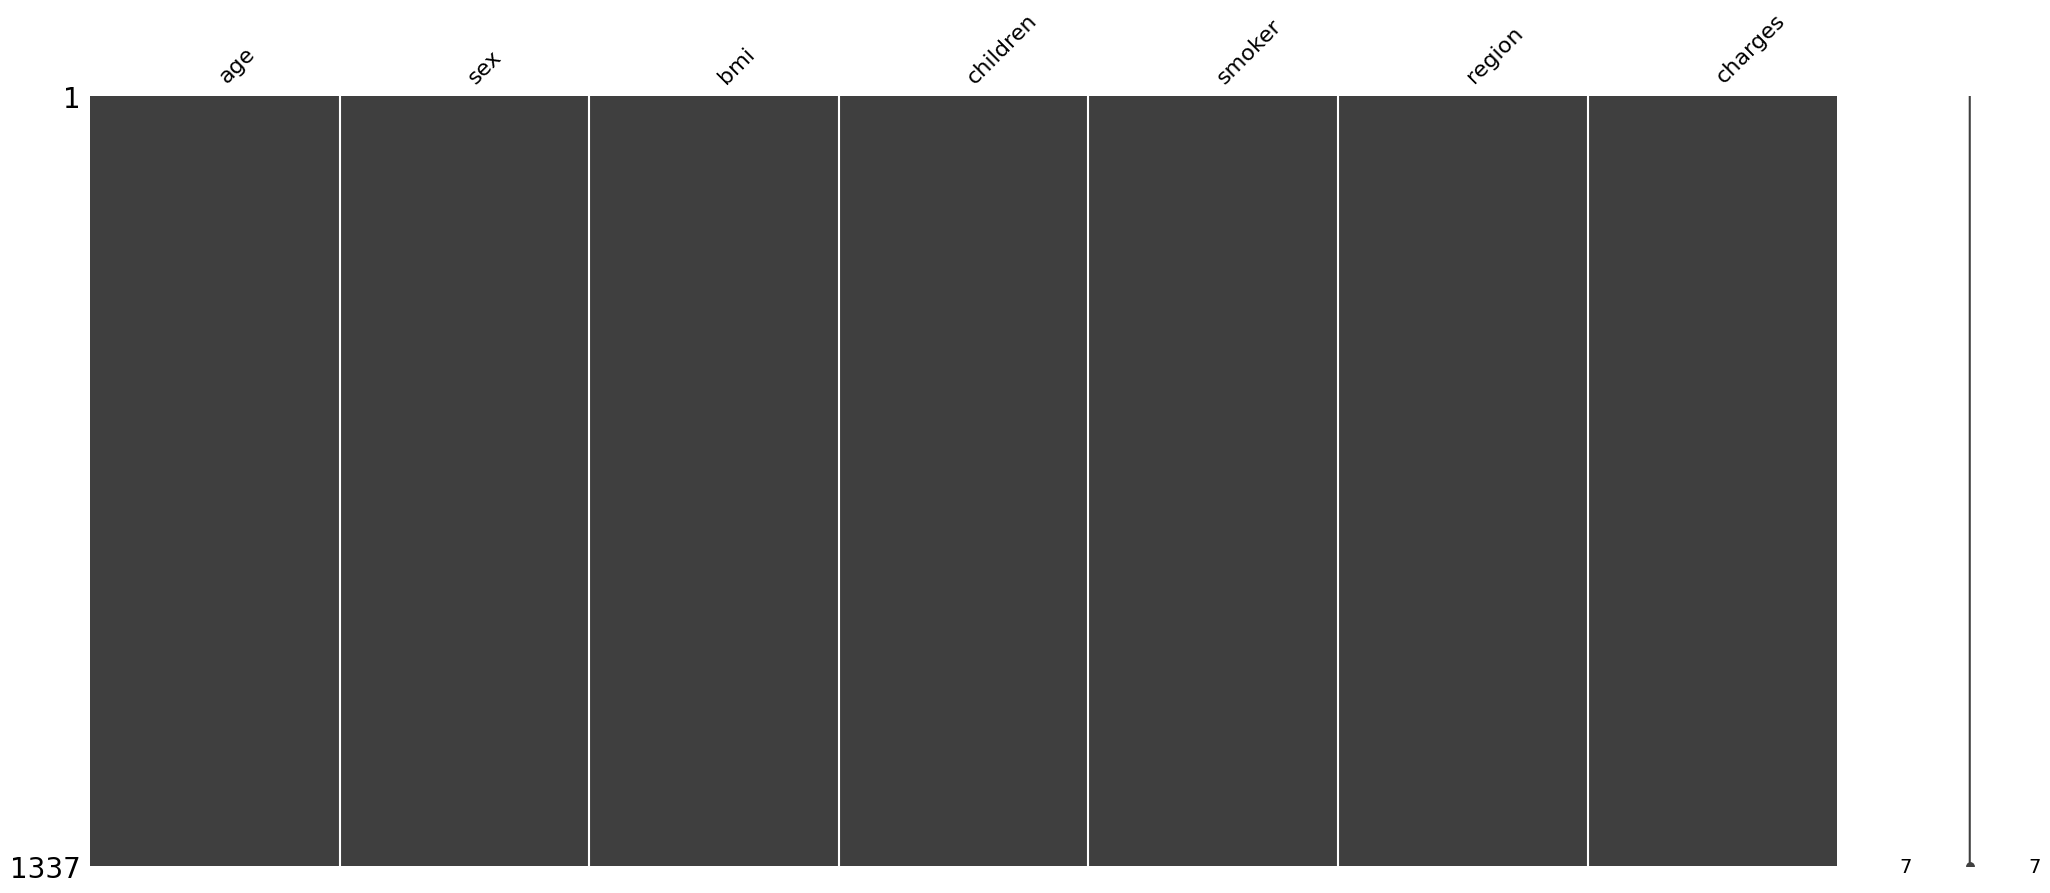

In [52]:
msno.matrix(df)

## 2. Détection des valeurs aberrantes

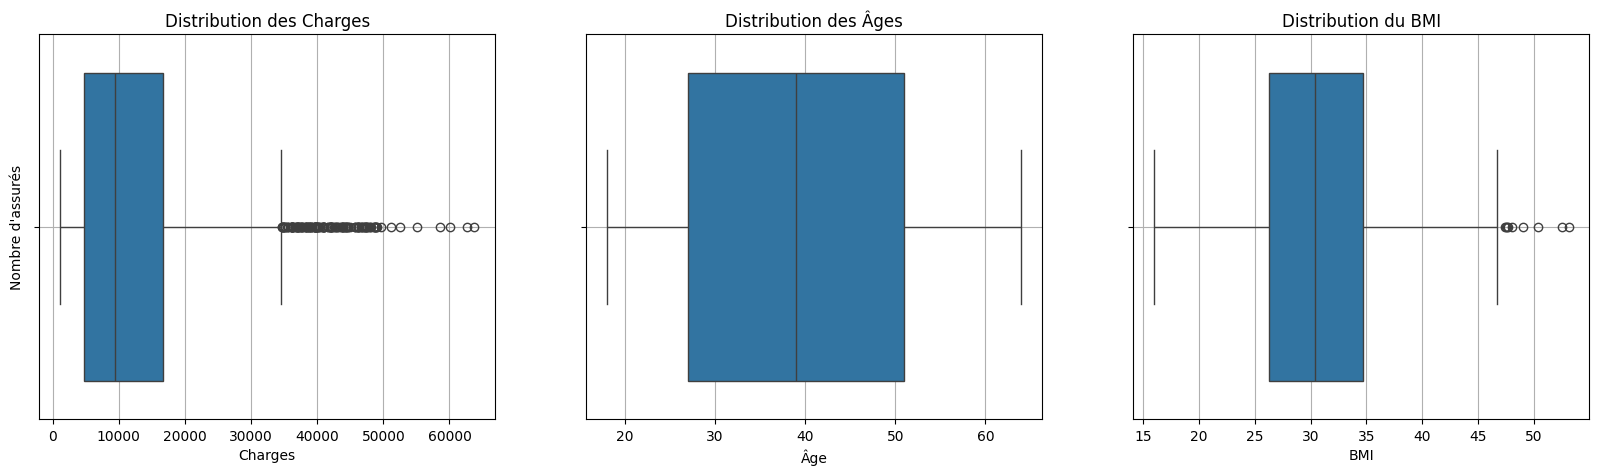

In [53]:
### Boîtes à moustache de nos variables quantitatives pour déterminer les valeurs aberrantes

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Graphique 1 : Distribution des charges
sns.boxplot(x=df['charges'], ax=axes[0])
axes[0].set_title("Distribution des Charges")
axes[0].set_xlabel("Charges")
axes[0].set_ylabel("Nombre d'assurés")

# Graphique 2 : Distribution des âges
sns.boxplot(x=df['age'], ax=axes[1])
axes[1].set_title("Distribution des Âges")
axes[1].set_xlabel("Âge")
axes[1].set_ylabel("")


# Graphique 3 : Distribution du BMI
sns.boxplot(x=df['bmi'], ax=axes[2])
axes[2].set_title("Distribution du BMI")
axes[2].set_xlabel("BMI")
axes[2].set_ylabel("")

for i in range(3):
    axes[i].grid()
    
plt.show()

In [54]:
### Recherches des valeurs aberrantes

def valeurs_aberrantes_IQR(df, colonne) : 
    Q1 = df[colonne].quantile(0.25)
    Q3 = df[colonne].quantile(0.75)
    IQR = Q3 - Q1

    limite_inf = Q1 - (1.5 * IQR)
    limite_sup = Q3 + (1.5 * IQR)

    valeurs_aberrantes = df[(df[colonne] < limite_inf) | (df[colonne] > limite_sup)]
    
    return valeurs_aberrantes

In [55]:
# Valeurs aberrantes de la variable cible "charges"

charges_outliers = valeurs_aberrantes_IQR(df, 'charges')
charges_outliers.sort_values('charges', ascending=False)

,age,sex,bmi,children,smoker,region,charges
543,54,female,47.410,0,yes,southeast,63770.42801
1300,45,male,30.360,0,yes,southeast,62592.87309
1230,52,male,34.485,3,yes,northwest,60021.39897
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
...,...,...,...,...,...,...,...
1291,19,male,34.900,0,yes,southwest,34828.65400
689,27,male,31.130,1,yes,southeast,34806.46770
223,19,male,34.800,0,yes,southwest,34779.61500
1078,28,male,31.680,0,yes,southeast,34672.14720


In [56]:
print(f"- Nombre de lignes contenant des valeurs abérantes : {charges_outliers.shape[0]}")
print(f"- Pourgentage de lignes contenant des valeurs abérantes : {round((charges_outliers.shape[0] / df.shape[0]) * 100,2)} %")

- Nombre de lignes contenant des valeurs abérantes : 139
- Pourgentage de lignes contenant des valeurs abérantes : 10.4 %


In [57]:
# Vérification des données : Age
print("Vérification des données : Âge")
print(f"Valeur minimale : {min(df['age'])}")
print(f"Valeur maximale : {max(df['age'])}")
print(f"Type de données : {df['age'].dtype}\n")

print("Observation : Les données sur l'âge semblent correctes et ne contiennent pas de valeurs aberrantes.\n")

# Vérification des données : BMI
print("Vérification des données : BMI")
print(f"Valeur minimale : {min(df['bmi']):.2f}")
print(f"Valeur maximale : {max(df['bmi']):.2f}\n")

print("Observation : Bien qu'il n'existe pas de limites strictes au BMI, une valeur inférieure à 16 indique une insuffisance pondérale sévère, et une valeur supérieure à 40 représente une obésité de classe 3 (sévère).")
print("Nous pourrions donc considérer que des valeurs en dehors de cet intervalle sont potentiellement aberrantes.\n")

# Vérification des données : Nombre d'enfants
print("Vérification des données : Nombre d'enfants")
print(f"Valeur minimale : {min(df['children'])}")
print(f"Valeur maximale : {max(df['children'])}")
print(f"Type de données : {df['children'].dtype}\n")

print("Observation : Les données sur le nombre d'enfants semblent correctes et ne contiennent pas de valeurs aberrantes.\n")

# Conclusion
print("Conclusion : Après ces observations, nous allons examiner plus en détail les valeurs de la colonne BMI.")


Vérification des données : Âge
Valeur minimale : 18
Valeur maximale : 64
Type de données : int64

Observation : Les données sur l'âge semblent correctes et ne contiennent pas de valeurs aberrantes.

Vérification des données : BMI
Valeur minimale : 15.96
Valeur maximale : 53.13

Observation : Bien qu'il n'existe pas de limites strictes au BMI, une valeur inférieure à 16 indique une insuffisance pondérale sévère, et une valeur supérieure à 40 représente une obésité de classe 3 (sévère).
Nous pourrions donc considérer que des valeurs en dehors de cet intervalle sont potentiellement aberrantes.

Vérification des données : Nombre d'enfants
Valeur minimale : 0
Valeur maximale : 5
Type de données : int64

Observation : Les données sur le nombre d'enfants semblent correctes et ne contiennent pas de valeurs aberrantes.

Conclusion : Après ces observations, nous allons examiner plus en détail les valeurs de la colonne BMI.


In [58]:
bmi_outliers = valeurs_aberrantes_IQR(df, 'bmi')
bmi_outliers.sort_values('bmi', ascending=False)

,age,sex,bmi,children,smoker,region,charges
1317,18,male,53.13,0,no,southeast,1163.46270
1047,22,male,52.58,1,yes,southeast,44501.39820
847,23,male,50.38,1,no,southeast,2438.05520
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
1088,52,male,47.74,1,no,southeast,9748.91060
860,37,female,47.60,2,yes,southwest,46113.51100
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801


In [59]:
print(f"- Nombre de lignes contenant des valeurs abérantes : {bmi_outliers.shape[0]}")
print(f"- Pourgentage de lignes contenant des valeurs abérantes : {round((bmi_outliers.shape[0] / df.shape[0]) * 100,2)} %")

- Nombre de lignes contenant des valeurs abérantes : 9
- Pourgentage de lignes contenant des valeurs abérantes : 0.67 %


In [60]:
df[df['bmi'] < 16]

,age,sex,bmi,children,smoker,region,charges
172,18,male,15.96,0,no,northeast,1694.7964


In [61]:
df[df['bmi'] > 40]

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.13,0,yes,southeast,39611.7577
18,56,male,40.30,0,no,southwest,10602.3850
83,48,female,41.23,4,no,northwest,11033.6617
116,58,male,49.06,0,no,southeast,11381.3254
170,63,male,41.47,0,no,southeast,13405.3903
...,...,...,...,...,...,...,...
1240,52,male,41.80,2,yes,southeast,47269.8540
1312,34,male,42.90,1,no,southwest,4536.2590
1317,18,male,53.13,0,no,southeast,1163.4627
1323,42,female,40.37,2,yes,southeast,43896.3763


In [62]:
df.to_csv('dataset_assurance_cleaned.csv', index=False)

# 3 | Analyse univariée

In [63]:
# Résumer statistiques de nos variables

summary_stats = df.describe().transpose()
summary_stats['median'] = df.select_dtypes('number').median()

summary_stats

,count,mean,std,min,25%,50%,75%,max,median
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000,39.0000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000,30.4000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000,1.0000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801,9386.1613


### 1. Répartition des caractéristiques démographiques et sociales

Text(0.5, 1.0, 'Proportion des enfants par assurés')

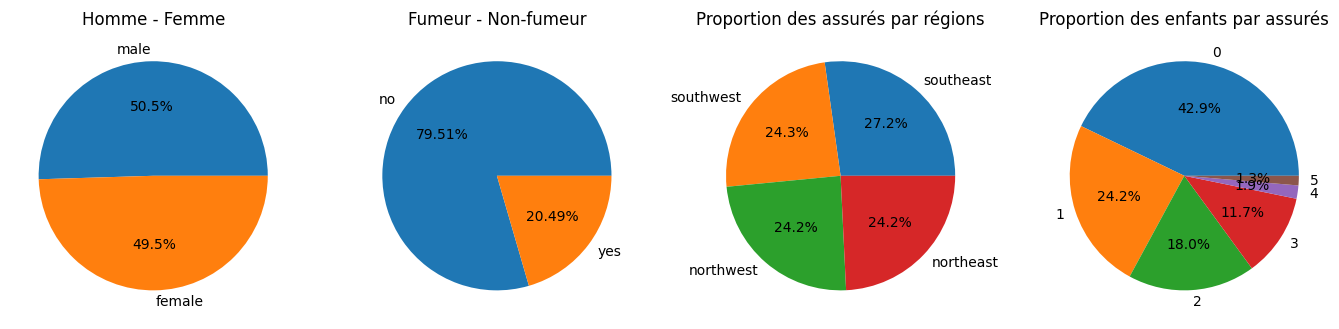

In [64]:
### Répartition des variables

fig, axes = plt.subplots(1, 4, figsize=(17, 4))

## Proportion Homme-Femmme
axes[0].pie(df["sex"].value_counts(), labels=df["sex"].value_counts().index, autopct='%1.1f%%')
axes[0].set_title("Homme - Femme")

## Proportion des fumeurs
axes[1].pie(df["smoker"].value_counts(), labels=df["smoker"].value_counts().index, autopct='%1.2f%%')
axes[1].set_title("Fumeur - Non-fumeur")

## Proportions des assurés par régions
axes[2].pie(df["region"].value_counts(), labels=df["region"].value_counts().index, autopct='%1.1f%%')
axes[2].set_title("Proportion des assurés par régions")

## Proportions des enfants par assurés
axes[3].pie(df["children"].value_counts(), labels=df["children"].value_counts().index, autopct='%1.1f%%')
axes[3].set_title("Proportion des enfants par assurés")


### 2. Distributions de nos variables

<Axes: xlabel='charges', ylabel='Count'>

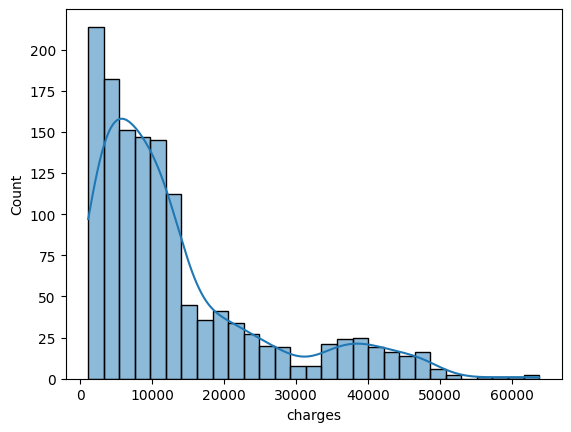

In [65]:
### Distribution de notre variable cible 'charges'

sns.histplot(df['charges'], kde=True)

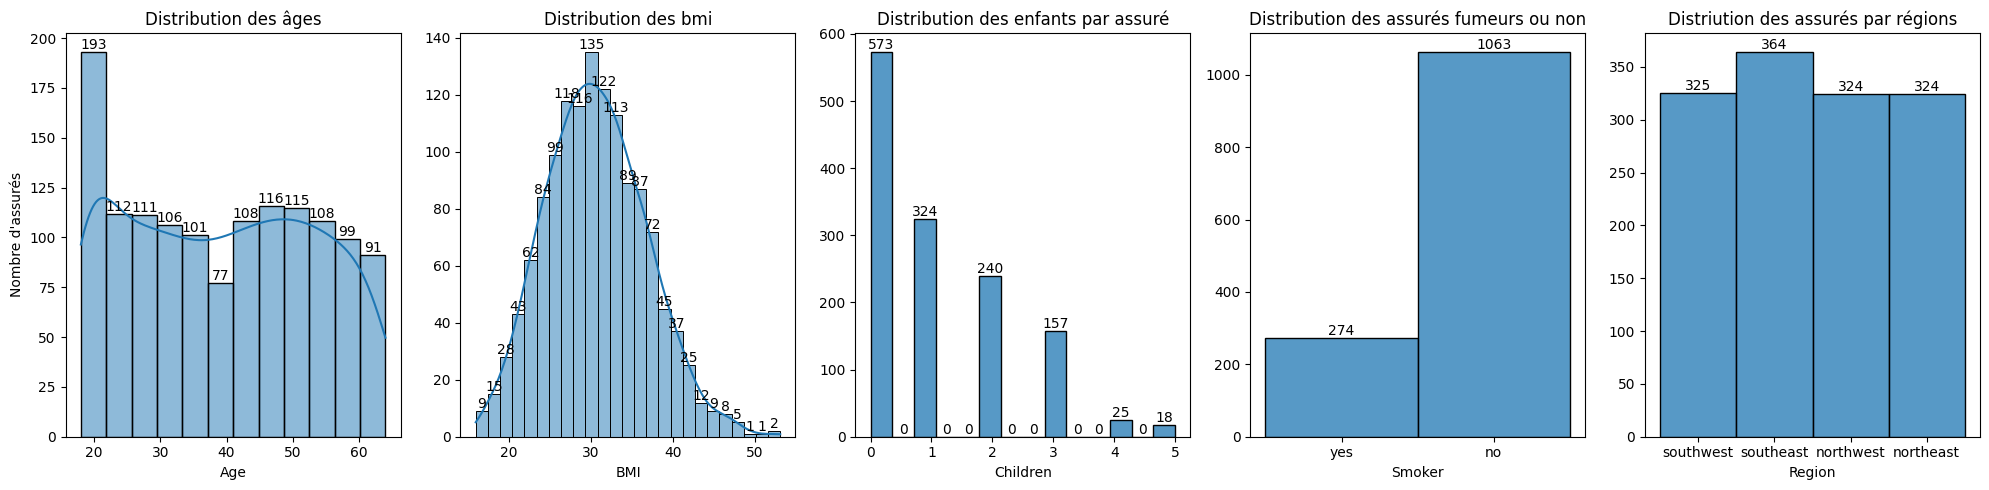

In [66]:
### Distribution de nos variables


fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Graphique 1 : Distribution des âges
sns.histplot(df['age'], kde=True, ax=axes[0])
axes[0].set_title("Distribution des âges")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Nombre d'assurés")
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.0f')

# Graphique 2 : Distribution du BMI
sns.histplot(df['bmi'], kde=True, ax=axes[1])
axes[1].set_title("Distribution des bmi")
axes[1].set_xlabel("BMI")
axes[1].set_ylabel("")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.0f')

# Graphique 3 : Distribution du nombre d'enfants
sns.histplot(df['children'], ax=axes[2])
axes[2].set_title("Distribution des enfants par assuré")
axes[2].set_xlabel("Children")
axes[2].set_ylabel("")
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%.0f')

# Graphique 4 : Distribution des assurés suivant s'ils sont fumeurs ou non-fumeurs
sns.histplot(df['smoker'], ax=axes[3])
axes[3].set_title("Distribution des assurés fumeurs ou non")
axes[3].set_xlabel("Smoker")
axes[3].set_ylabel("")
for container in  axes[3].containers:
    axes[3].bar_label(container, fmt='%.0f')

# Graphique 5 : Distribution des assurés par régions
sns.histplot(df['region'], ax=axes[4])
axes[4].set_title("Distriution des assurés par régions")
axes[4].set_xlabel("Region")
axes[4].set_ylabel("")
for container in axes[4].containers:
    axes[4].bar_label(container, fmt='%.0f')

plt.tight_layout()
plt.show()

# 4 | Corrélation des variables

In [67]:
### Encodage de nos variables qualitatives pour le schéma de corrélations

encoder = LabelEncoder()

df_encoded = df.copy()

df_encoded['sex_encoded'] = encoder.fit_transform(df_encoded['sex'])
df_encoded['region_encoded'] = encoder.fit_transform(df_encoded['region'])
df_encoded['smoker_encoded'] =  encoder.fit_transform(df_encoded['smoker'])

df_encoded = df_encoded[['age', 'sex_encoded', 'bmi', 'children', 'smoker_encoded', 'region_encoded', 'charges']]
df_encoded

,age,sex_encoded,bmi,children,smoker_encoded,region_encoded,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


<Axes: >

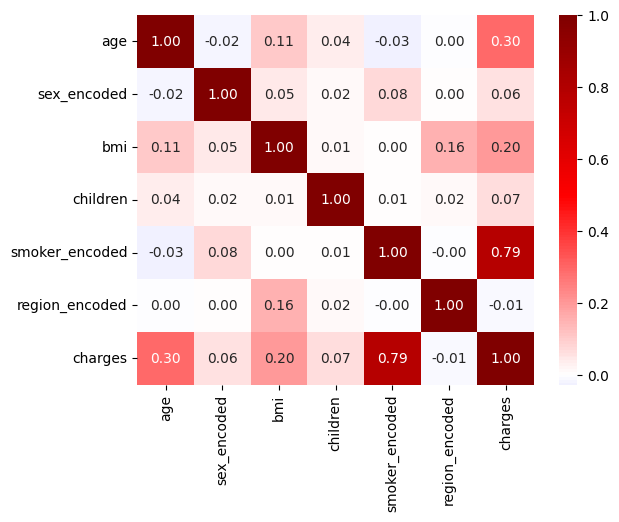

In [68]:
### Heatmap des corrélations


# Corrélation
df_corr = df_encoded.select_dtypes('number').corr()

# HeatMap
sns.heatmap(df_corr, annot = True, fmt='.2f', cmap='seismic', center=0)


# 5 | Analyse Bivariés

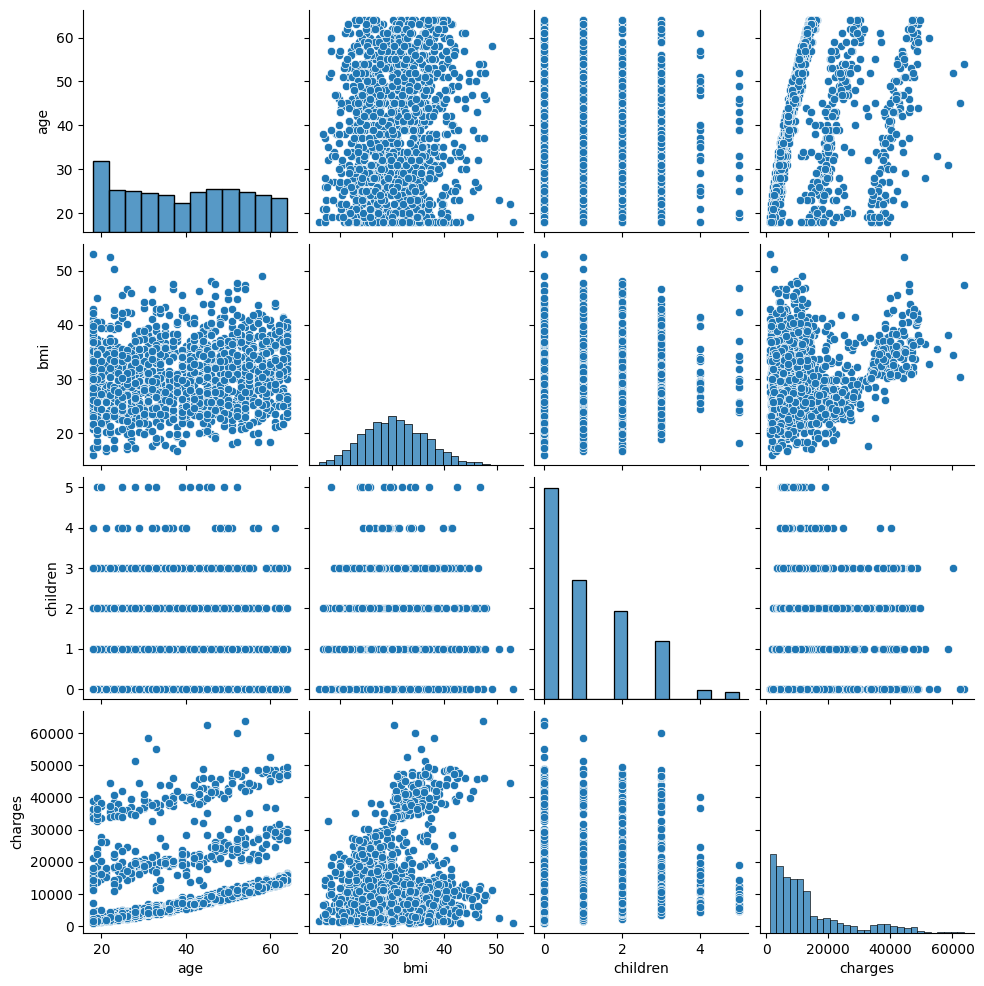

In [69]:
sns.pairplot(df.select_dtypes('number'))

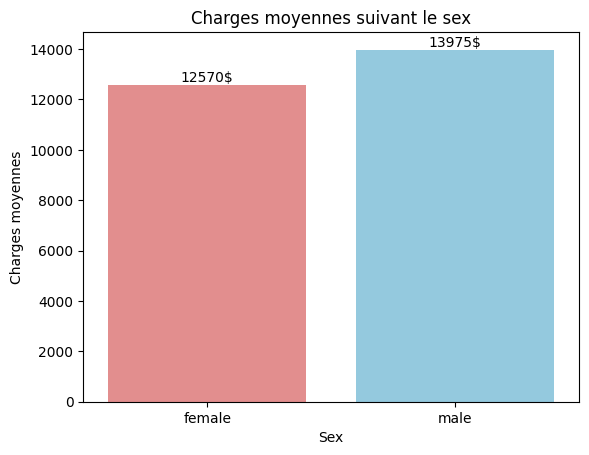

In [70]:
# Relation entre le sex et les charges

sns.barplot(data=df, x='sex', y='charges', estimator='mean', hue='sex', palette=['lightcoral', 'skyblue'], errorbar=None)

# Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

# Personnalisation
plt.xlabel("Sex")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes suivant le sex")
plt.show()


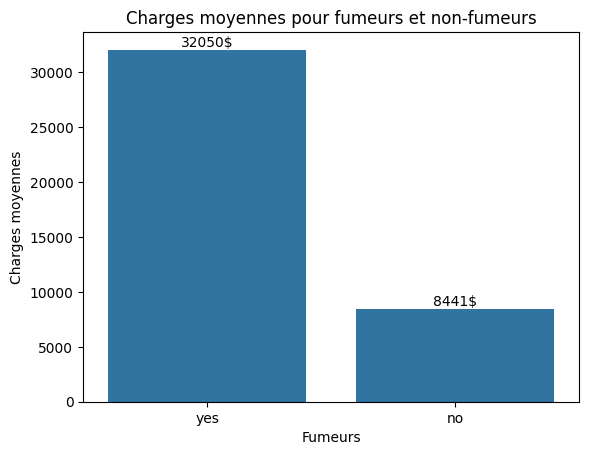

In [71]:
# Relation entre le fait de fumer et les charges

## BarPlot
sns.barplot(data=df, x='smoker', y='charges', estimator='mean', errorbar=None)

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

#"" Personnalisation
plt.xlabel("Fumeurs")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes pour fumeurs et non-fumeurs")
plt.show()

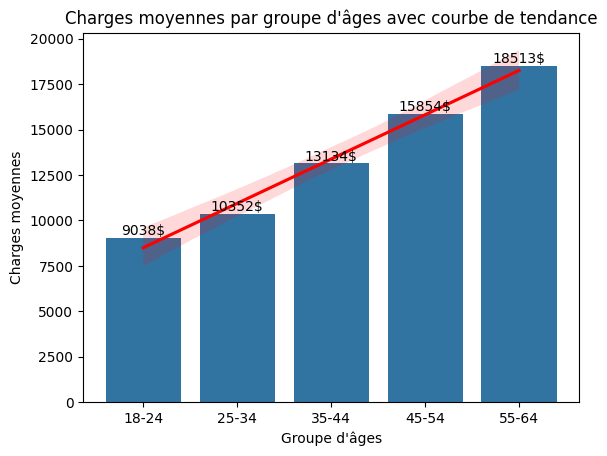

In [72]:
# Relation entre l'âge et les charges

df['age_group'] = pd.cut(
    df['age'],
    bins=[17, 24, 34, 44, 54, 64],                             
    labels=['18-24', '25-34', '35-44', '45-54', '55-64']
)

age_group_mapping = {'18-24': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55-64': 4}
df['age_group_numeric'] = df['age_group'].map(age_group_mapping)

# BarPlot
sns.barplot(data=df, x='age_group', y='charges', estimator='mean', errorbar=None)

# Courbe de tendance avec regplot (régression linéaire)
sns.regplot(data=df, x='age_group_numeric', y='charges', scatter=False, color='red')

# Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

# Personnalisation
plt.xlabel("Groupe d'âges")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par groupe d'âges avec courbe de tendance")
plt.show()

In [73]:
pd.pivot_table(data=df, 
               values='charges', 
               index='age_group',   
               aggfunc=['count', 'mean', 'median', 'std'],
               observed=True
               ).round(2)

,count,mean,median,std
,charges,charges,charges,charges
age_group,,,,
18-24,277,9037.95,2457.50,11808.09
25-34,271,10352.39,4718.20,11424.01
35-44,260,13134.17,7205.60,11788.98
45-54,287,15853.93,10115.01,11725.30
55-64,242,18513.28,13226.77,11352.69


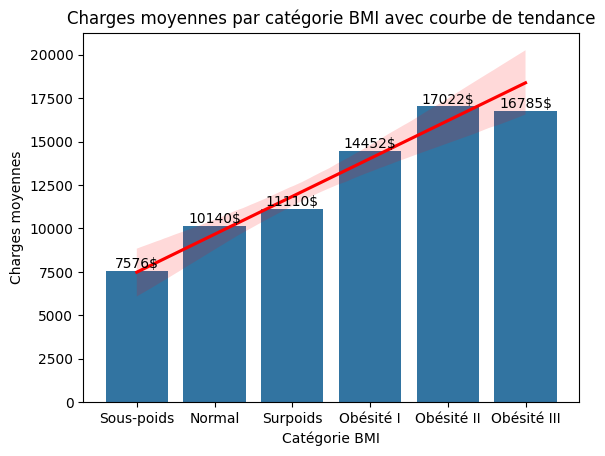

In [74]:
# Relation entre le BMI et les charges

## Création des catégories de BMI
def bmi_category(bmi):
    if bmi < 18:
        return "Sous-poids"
    elif bmi < 24.5:
        return "Normal"
    elif bmi < 30:
        return "Surpoids"
    elif bmi < 35:
        return "Obésité I"
    elif bmi < 40:
        return "Obésité II"
    else:
        return "Obésité III"

df["bmi_cat"] = df["bmi"].apply(bmi_category)

## Mapping de BMI
bmi_mapping = {'Sous-poids': 0,'Normal': 1, 'Surpoids': 2, 'Obésité I': 3, 'Obésité II': 4, 'Obésité III': 5}

df['bmi_cat_numeric'] = df['bmi_cat'].map(bmi_mapping)

## BarPlot
sns.barplot(data=df, x='bmi_cat', y='charges', estimator="mean", errorbar=None, order=bmi_mapping.keys())

## Courbe de tendance avec regplot (régression linéaire)
sns.regplot(data=df, x='bmi_cat_numeric', y='charges', scatter=False, color='red')

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

## Personnalisation
plt.xlabel("Catégorie BMI")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par catégorie BMI avec courbe de tendance")
plt.show()

In [75]:
pd.pivot_table(data=df, 
               values='charges',  # On peut utiliser n'importe quelle colonne ici
               index='bmi_cat',   # C'est la colonne pour laquelle on veut les catégories
               aggfunc=['count', 'mean', 'median', 'std'],
               ).reindex(bmi_mapping).round(2)

,count,mean,median,std
,charges,charges,charges,charges
bmi_cat,,,,
Sous-poids,15,7576.42,3732.63,8370.27
Normal,203,10139.76,8603.82,7246.19
Surpoids,413,11109.70,8823.28,8079.05
Obésité I,390,14452.44,9573.46,13575.10
Obésité II,225,17022.26,11264.54,15171.51
Obésité III,91,16784.62,9748.91,16658.19


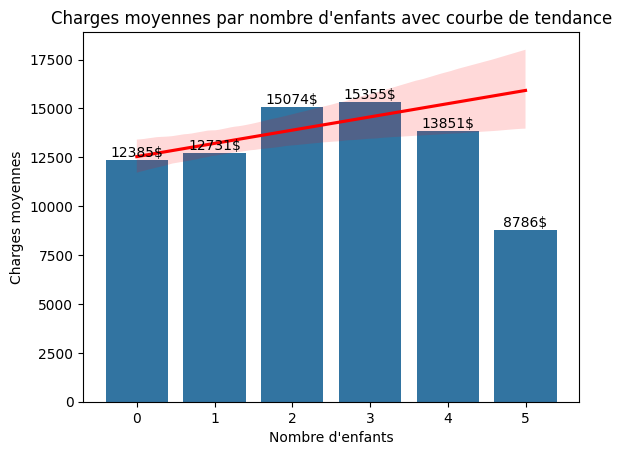

In [76]:
# Relation entre le nombre d'enfants et les charges

## BarPlot
sns.barplot(data=df, x='children', y='charges', errorbar=None)
sns.regplot(data=df, x='children', y='charges', scatter=False, color='red')

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

## Personnalisation
plt.xlabel("Nombre d'enfants")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par nombre d'enfants avec courbe de tendance")
plt.show()

In [77]:
pd.pivot_table(data=df, 
               values='charges',
               index='children',
               aggfunc=['count', 'mean', 'median', 'std']
               ).round(2)

,count,mean,median,std
,charges,charges,charges,charges
children,,,,
0,573,12384.70,9863.47,12025.42
1,324,12731.17,8483.87,11823.63
2,240,15073.56,9264.98,12891.37
3,157,15355.32,10600.55,12330.87
4,25,13850.66,11033.66,9139.22
5,18,8786.04,8589.57,3808.44


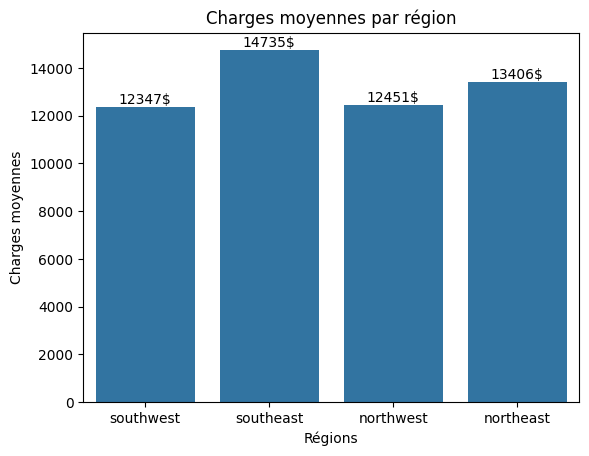

In [78]:
# Relation entre le nombre d'enfants et les charges

## BarPlot
sns.barplot(data=df, x='region', y='charges', estimator='mean', errorbar=None)

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

## Personnalisation
plt.xlabel("Régions")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par région")
plt.show()

In [79]:
pd.crosstab(df["sex"], df["region"])

region,northeast,northwest,southeast,southwest
sex,,,,
female,161,164,175,162
male,163,160,189,163


In [80]:
pd.crosstab(df["smoker"], df["region"])

region,northeast,northwest,southeast,southwest
smoker,,,,
no,257,266,273,267
yes,67,58,91,58


In [81]:
df.groupby(['sex', 'smoker'])['charges'].describe()

count          mean           std         min           25%  \
sex    smoker                                                                
female no      547.0   8762.297300   6060.775970   1607.5101   4265.599100   
       yes     115.0  30678.996276  11907.536381  13844.5060  19696.432100   
male   no      516.0   8099.700161   5907.000174   1121.8739   3684.907500   
       yes     159.0  33042.005975  11202.670862  12829.4551  21241.526875   

                        50%          75%          max  
sex    smoker                                          
female no       7639.417450  11786.16660  36910.60803  
       yes     28950.469200  40918.31450  63770.42801  
male   no       6986.101975  10960.85900  32108.66282  
       yes     36085.219000  41797.58905  62592.87309

In [82]:
df.groupby(['sex', 'region'])['charges'].describe()

count          mean           std         min          25%  \
sex    region                                                                  
female northeast  161.0  12953.203151  10591.929980  2196.47320  5458.046450   
       northwest  164.0  12479.870397  10596.572843  2117.33885  4918.789338   
       southeast  175.0  13499.669243  12587.261506  1607.51010  4382.836600   
       southwest  162.0  11274.411264  10453.660658  1727.78500  4895.811250   
male   northeast  163.0  13854.005374  11890.942381  1694.79640  4880.990000   
       northwest  160.0  12421.085552  11574.543615  1621.34020  4449.280962   
       southeast  189.0  15879.617173  15083.360816  1121.87390  4463.205100   
       southwest  163.0  13412.883576  12499.550025  1241.56500  4658.699500   

                           50%           75%          max  
sex    region                                              
female northeast  10197.772200  15359.104500  58571.07448  
       northwest   9614.072900  14492.722725  55135.40209  
       southeast   8582.302300  18220.806295  63770.42801  
       southwest   8530.837000  12642.990500  48824.45000  
male   northeast   9957.721600  18276.474375  48549.17835  
       northwest   8420.766175  15976.212950  60021.39897  
       southeast   9504.310300  21978.676900  62592.87309  
       southwest   9391.346000  17119.976000  52590.82939

In [83]:
df.groupby(['smoker', 'region'])['charges'].describe()

count          mean           std         min           25%  \
smoker region                                                                   
no     northeast  257.0   9165.531672   6157.196439   1694.7964   4438.263400   
       northwest  266.0   8582.467101   6125.331366   1621.3402   4201.807987   
       southeast  273.0   8032.216309   6137.329758   1121.8739   3471.409600   
       southwest  267.0   8019.284513   5489.514421   1241.5650   3947.026500   
yes    northeast   67.0  29673.536473  11589.559770  12829.4551  19881.400425   
       northwest   58.0  30192.003182  11413.827702  14711.7438  20834.130337   
       southeast   91.0  34844.996824  11324.766536  16577.7795  23155.105450   
       southwest   58.0  32269.063494  11270.279593  13844.5060  20396.042022   

                           50%           75%          max  
smoker region                                              
no     northeast   8342.908750  11938.255950  32108.66282  
       northwest   7259.232050  11355.802575  33471.97189  
       southeast   6652.528800  10982.501300  36580.28216  
       southwest   7348.142000  11017.990500  36910.60803  
yes    northeast  28101.333050  39576.950850  58571.07448  
       northwest  27488.996475  39918.948975  60021.39897  
       southeast  37484.449300  43391.859400  63770.42801  
       southwest  35165.256500  39809.292750  52590.82939

# 6 | Tests statistiques

### 1. Test de normalités

In [84]:
variables = ['charges', 'age', 'bmi']

results = []

# Test de normalité sur chaque variable
for var in variables:
    stat, p_value = stats.normaltest(df[var])
    results.append({
        'Variable': var,
        'Statistique': stat,
        'p-value': p_value,
        'Normalité': 'Rejetée' if p_value < 0.05 else 'Acceptée'
    })
    
# Ajouter les résultats après transformation logarithmique pour 'charges'
stat, p_value = stats.normaltest(np.log(df["charges"]))
results.append({
    'Variable': 'charges (log)',
    'Statistique': stat,
    'p-value': p_value,
    'Normalité': 'Rejetée' if p_value < 0.05 else 'Acceptée'
})

norm_test_df = pd.DataFrame(results)
norm_test_df


,Variable,Statistique,p-value,Normalité
0,charges,336.441607,8.762608e-74,Rejetée
1,age,1545.392166,0.000000e+00,Rejetée
2,bmi,17.564425,1.534382e-04,Rejetée
3,charges (log),52.147628,4.745549e-12,Rejetée


### 2. Tests de régression univariée

In [85]:
# Charges & Âges

print(smf.ols('charges ~ age', data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     130.4
Date:                Tue, 14 Jan 2025   Prob (F-statistic):           6.98e-29
Time:                        15:04:43   Log-Likelihood:                -14405.
No. Observations:                1337   AIC:                         2.881e+04
Df Residuals:                    1335   BIC:                         2.882e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3190.0217    938.396      3.399      0.0

Le modèle n'explique qu'environ 8.9 % de la variance des charges, ce qui est très faible. Cela signifie que d'autres variables (comme bmi, smoker, ou sex) sont probablement importantes pour expliquer les variations des charges.

Bien que age ait un effet significatif sur les charges, cet effet est relativement faible (257.23 unités monétaires par an).

Les résidus ne sont pas normalement distribués, ce qui pourrait affecter la validité des tests statistiques. Cela peut être dû à l'absence d'autres variables importantes dans le modèle.

In [86]:
# Charges & BMI

print(smf.ols('charges ~ bmi', data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     54.70
Date:                Tue, 14 Jan 2025   Prob (F-statistic):           2.47e-13
Time:                        15:04:43   Log-Likelihood:                -14440.
No. Observations:                1337   AIC:                         2.888e+04
Df Residuals:                    1335   BIC:                         2.889e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1202.1404   1664.857      0.722      0.4

R² = 0.039 : 3.9 % de la variabilité des charges est expliquée par l’IMC.
Le coefficient (393.86) montre qu’une augmentation d’une unité de l’IMC est associée à une augmentation moyenne de 393.86 unités monétaires des charges.

Le test global du modèle (F−statistic = 54.70) est également significatif (P=2.47×10^(−13)), confirmant que bmi apporte une information utile pour expliquer charges.

Bien que bmi ait un effet significatif sur charges, il ne suffit pas à expliquer les variations importantes des coûts médicaux. 

In [87]:
# Fumeurs

print(smf.ols('charges ~ smoker', data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     2176.
Date:                Tue, 14 Jan 2025   Prob (F-statistic):          1.41e-282
Time:                        15:04:43   Log-Likelihood:                -13820.
No. Observations:                1337   AIC:                         2.764e+04
Df Residuals:                    1335   BIC:                         2.766e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8440.6603    229.137     36.837

R² = 0.62 : Cela signifie que 62 % de la variation des charges médicales est expliquée par la variable explicative "smoker" (le statut de fumeur).
Ce résultat indique une bonne capacité explicative du modèle. Un R² aussi élevé montre que le statut de fumeur a un impact significatif sur les charges médicales.

smoker[T.yes] = 23 610,00 : Cela signifie que les charges médicales sont en moyenne 23 610 unités monétaires plus élevées pour un fumeur comparé à un non-fumeur.

F-statistic = 2176 et p-value associée = 1.41e-282 : Le test F est très significatif (p-value extrêmement faible), ce qui confirme que le modèle dans son ensemble est bien ajusté et que la variable explicative "smoker" contribue de manière importante à la prédiction des charges.

In [88]:
# Charges & Enfants

print(smf.ols('charges ~ children', data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.090
Date:                Tue, 14 Jan 2025   Prob (F-statistic):             0.0137
Time:                        15:04:43   Log-Likelihood:                -14464.
No. Observations:                1337   AIC:                         2.893e+04
Df Residuals:                    1335   BIC:                         2.894e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.254e+04    446.786     28.061      0.0

R² = 0.005 : Cela signifie que seulement 0,5 % de la variation des charges médicales est expliquée par le nombre d'enfants. Un R² aussi faible suggère que le modèle n'explique pratiquement rien de la variation des charges.

In [89]:
# Regions

print(smf.ols('charges ~ region', data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.926
Date:                Tue, 14 Jan 2025   Prob (F-statistic):             0.0328
Time:                        15:04:43   Log-Likelihood:                -14462.
No. Observations:                1337   AIC:                         2.893e+04
Df Residuals:                    1333   BIC:                         2.895e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.341e+04    

R² = 0.007 : Cela suggère que les variables indépendantes incluses dans le modèle n'ont qu'une influence marginale sur charges.

Variables catégorielles "region" :
* "northwest" : Le coefficient est de -955,54, mais avec une valeur p de 0,314, ce qui indique que cette variable n'a pas d'effet statistiquement significatif sur "charges".
* "southeast" : Le coefficient est de 1 329,03, avec une valeur p de 0,150, suggérant également un effet non significatif.
* "southwest" : Le coefficient est de -1 059,45, avec une valeur p de 0,264, indiquant un effet non significatif.
Aucune des variables "region" n'a d'effet statistiquement significatif sur "charges" dans ce modèle.


F-statistic : La valeur est de 2,926 avec une valeur p de 0,0328, indique que le modèle dans son ensemble est significatif. Bien que le modèle global soit statistiquement significatif, les variables régionales incluses n'ont pas d'effet significatif sur charges. De plus, les résidus ne suivent pas une distribution normale, ce qui pourrait affecter la validité des résultats.

### 3. Test de régression multivarié

In [90]:
df_encoded

,age,sex_encoded,bmi,children,smoker_encoded,region_encoded,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [91]:
X = df_encoded.drop(columns='charges')
y = df['charges']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     667.0
Date:                Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                        15:04:43   Log-Likelihood:                -13539.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1330   BIC:                         2.713e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.181e+04    955.719    -12.

Les résultats de la régression linéaire multiple indiquent que le modèle explique environ 75,1 % de la variance des charges médicales, ce qui est relativement élevé. Les variables indépendantes significatives comprennent l'âge, l'indice de masse corporelle (IMC), le nombre d'enfants, le statut de fumeur et la région. En revanche, le sexe n'a pas d'effet statistiquement significatif sur les charges médicales dans ce modèle.

R² = 0,751 : Le modèle explique environ 75,1% de la variance de la variable dépendante "charges". Cela signifie que le modèle est relativement performant.
Adj. R² = 0,749 : L'ajustement prend en compte le nombre de variables explicatives, ce qui reste très bon. L'ajustement montre qu'il y a très peu de perte de performance lorsque l'on ajuste pour la complexité du modèle.

F-statistic = 667,0 avec une p-value proche de 0 : Cela signifie que le modèle dans son ensemble est très significatif et que la probabilité que les résultats soient dus au hasard est extrêmement faible.


* **age** : Le coefficient est 257,20, avec une p-value = 0,000. Cela montre que l'âge a un effet statistiquement significatif sur les charges (une augmentation de l'âge de 1 an est associée à une augmentation de 257,20 unités des charges).

* **sex_encoded** : Le coefficient est de -129,40, mais avec une p-value = 0,698. Cela indique que le sexe n'a pas un effet significatif sur les charges.

* **bmi** : Le coefficient est 332,60, avec une p-value = 0,000. Cela montre que le BMI a un impact statistiquement significatif sur les charges (une augmentation du BMI de 1 unité est associée à une augmentation de 332,60 unités des charges).

* **children** : Le coefficient est 478,77, avec une p-value = 0,001. Cela montre qu'avoir des enfants a un effet positif et significatif sur les charges (chaque enfant supplémentaire est associé à une augmentation de 478,77 unités des charges).

* **smoker_encoded** : Le coefficient est de 23 820, avec une p-value = 0,000. Cela montre qu'être fumeur a un impact majeur et significatif sur les charges.

* **region_encoded** : Le coefficient est de -354,01, avec une p-value = 0,020. Cela montre que la région a un effet modéré mais significatif sur les charges (certaines régions entraînent une réduction ou une augmentation des charges par rapport à la moyenne).